In [264]:
# %matplotlib notebook

# import modules
import numpy as np
import pandas as pd
import re, os, glob
import matplotlib.pyplot as plt
import seaborn as sns

# Setup Seaborn
sns.set_style("darkgrid")
sns.set_context("notebook")


In [265]:
# Reading the data
data = pd.read_csv("tmp4ada7ljn.csv")

/var/folders/3t/kc4zlyzx54l62jhcqlvnbfwr0000gn/T/ipykernel_66509/3378332847.py:2: DtypeWarning: Columns (8,11,22) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("tmp4ada7ljn.csv")


In [266]:
data

,incident_number,exposure_number,alarm_date,alarm_time,incident_type,incident_description,estimated_property_loss,estimated_content_loss,district,city_section,...,street_number,street_prefix,street_name,street_suffix,street_type,address_2,xstreet_prefix,xstreet_name,xstreet_suffix,xstreet_type
0,23-0079768,0,2023-10-28,00:15:00,511,Lock-out,0,0,08,DO,...,1973,NaN,DORCHESTER,NaN,AVE,NaN,NaN,NaN,NaN,NaN
1,23-0079770,0,2023-10-28,00:17:02,552,Police matter,0,0,04,BO,...,9,NaN,TYLER,NaN,ST,NaN,NaN,NaN,NaN,NaN
2,23-0079772,0,2023-10-28,00:28:42,745,"Alarm system activation, no fire - unintentional",0,0,01,EB,...,1,NaN,RICE,NaN,ST,": @EAST BOSTON YACHT CLUB - 1 RICE ST, E",NaN,NaN,NaN,NaN
3,23-0079773,0,2023-10-28,00:34:14,500,"Service Call, other",0,0,04,BO,...,640,NaN,WASHINGTON,NaN,ST,: @MBTA STA-CHINATOWN,NaN,NaN,NaN,NaN
4,23-0079774,0,2023-10-28,00:46:55,553,Public service,0,0,07,DO,...,15,NaN,CARSON,NaN,ST,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
480520,14-0000176,0,2014-01-01,22:53:16,743,"Smoke detector activation, no fire - unintenti...",0,0,4,NaN,...,000840,NaN,HARRISON,NaN,AV,NaN,NaN,NaN,NaN,NaN
480521,14-0000177,0,2014-01-01,22:58:22,743,"Smoke detector activation, no fire - unintenti...",0,0,1,NaN,...,000020,NaN,WALDEMAR,NaN,AV,KJB REALITY TRUST,NaN,NaN,NaN,NaN
480522,14-0000178,0,2014-01-01,22:59:08,611,Dispatched & cancelled en route,0,0,3,NaN,...,000017,NaN,COURT,NaN,ST,LOBBY,NaN,NaN,NaN,NaN
480523,14-0000180,0,2014-01-01,23:36:43,600,"Good intent call, Other",0,0,4,NaN,...,000255,NaN,MASSACHUSETTS,NaN,AV,OUTSIDE,NaN,NaN,NaN,NaN


In [267]:
# droping if some cloums
columns_to_drop = ['street_suffix', 'street_type', 'address_2', 'xstreet_prefix', 'xstreet_name', 'xstreet_suffix', 'xstreet_type']
data = data.drop(columns=columns_to_drop)


In [268]:
# property_use is my target variable so I'm removing the rows who's having Nan values bcoz we can not fil with mean/medium or with mode.
data_cleaned = data.dropna(subset=['property_use'])
data.dropna(subset=['property_use'], inplace=True)

In [269]:
# EDA

In [270]:
data.to_csv('filename.csv', index=False)

In [271]:
# converting to years

data['alarm_date'] = pd.to_datetime(data['alarm_date'])
data['year'] = data['alarm_date'].dt.year

# Now 'year' column will have the year extracted from 'alarm_date'
print(data[['alarm_date', 'year']])

       alarm_date  year
0      2023-10-28  2023
1      2023-10-28  2023
3      2023-10-28  2023
5      2023-10-28  2023
8      2023-10-28  2023
...           ...   ...
480519 2014-01-01  2014
480520 2014-01-01  2014
480521 2014-01-01  2014
480523 2014-01-01  2014
480524 2014-01-01  2014

[458256 rows x 2 columns]


In [272]:
# Handle missing values
# For numeric columns, you can replace missing values with a placeholder or the mean/median
data['estimated_property_loss'].fillna(0, inplace=True)
data['estimated_content_loss'].fillna(0, inplace=True)

# For categorical data, you might want to replace missing values with a placeholder or the most common value
data['street_name'].fillna('Unknown', inplace=True)


In [273]:
# Convert zip codes to strings
data['zip'] = data['zip'].astype(str)

# Add leading zero for 4-digit zip codes
data['zip'] = np.where(data['zip'].str.len() == 4, '0' + data['zip'], data['zip'])

# Now the zip codes should have leading zeros and be of string type
print(data['zip'])

0         02124
1         02111
3         02111
5         02114
8         02135
          ...  
480519    02130
480520    02118
480521    02128
480523    02115
480524    02118
Name: zip, Length: 458256, dtype: object


In [274]:
#### Geographical area's

In [289]:
import geopandas as gpd
import pandas as pd
import folium

In [296]:
# zip code latitude and longitude data
zll = pd.read_csv('/Users/prajaktasable/Downloads/DataBase/2021_Gaz_zcta_national.txt', sep='\t', encoding = "ISO-8859-1", usecols=[0, 5, 6], names=['zip', 'lat', 'long'], header=0, dtype={'zip': object})

data['incident_type'] = pd.to_numeric(data['incident_type'], errors='coerce')

Series_100 = data[data.incident_type < 200]
# # count employees per zip code
zip_count = Series_100[Series_100.year == 2022]\
                .groupby('zip')\
                .agg(np.size)\
                .reset_index()\
                # .rename(columns={'incident_suffix': 'incident_num'})
zip_df = pd.merge(zip_count, zll, on='zip', how='inner')

In [297]:
# zip_count = data[data.year == 2022].groupby('zip').size().reset_index(name='count')
# zip_df = pd.merge(zip_count, zll, on='zip', how='inner')


In [298]:
boston = pd.read_csv('/Users/prajaktasable/Downloads/DataBase/ZIP_Codes.csv', names=['zip'], usecols=[1], dtype={'zip': object})
boston = boston.drop(0)

In [299]:
boston_100

,zip,incident_number,exposure_number,alarm_date,alarm_time,incident_type,incident_description,estimated_property_loss,estimated_content_loss,district,city_section,neighborhood,property_use,property_description,street_number,street_prefix,street_name,year,lat,long
0,02108,49,49,49,49,49,49,49,49,49,49,49,49,49,49,49,49,49,42.355097,-71.065737
1,02109,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,42.366919,-71.050416
2,02110,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,42.358254,-71.051927
3,02111,74,74,74,74,74,74,74,74,74,74,74,74,74,74,74,74,74,42.350680,-71.060527
4,02113,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,42.365264,-71.055222
5,02114,70,70,70,70,70,70,70,70,70,70,70,70,70,70,70,70,70,42.363651,-71.066888
6,02115,199,199,199,199,199,199,199,199,199,199,199,199,199,199,199,199,199,42.339422,-71.094531
7,02116,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,42.350979,-71.076591
8,02118,282,282,282,282,282,282,282,282,282,282,282,282,282,282,282,282,282,42.337860,-71.069805
9,02119,259,259,259,259,259,259,259,259,259,259,259,259,259,259,259,259,259,42.324066,-71.085188


In [300]:
# generate various zip code maps
boston_100 = pd.merge(zip_df, boston, on='zip', how='inner')
suburbs = zip_df[~zip_df['zip'].isin(boston_100['zip'])]

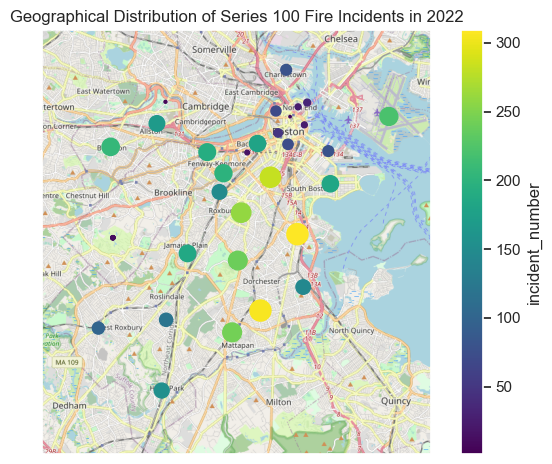

In [304]:
# map functions
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from cartopy.io.img_tiles import OSM
osm_tiles = OSM()


fig = plt.figure()
ax = plt.axes( projection= osm_tiles.crs)

# define map range (city of Boston)
img_extent = (-71.19, -70.985, 42.395, 42.23)
ax.set_extent(img_extent, ccrs.PlateCarree())

# add map image
ax.add_image(osm_tiles, 12)

# boston data
boston_100.plot('long','lat', kind='scatter', marker='.', s=boston_100['incident_number'].values*3, c='incident_number', cmap=plt.cm.viridis, ax=ax, transform=ccrs.PlateCarree())

ax.set_title('Geographical Distribution of Series 100 Fire Incidents in 2022')
plt.tight_layout()
plt.show()

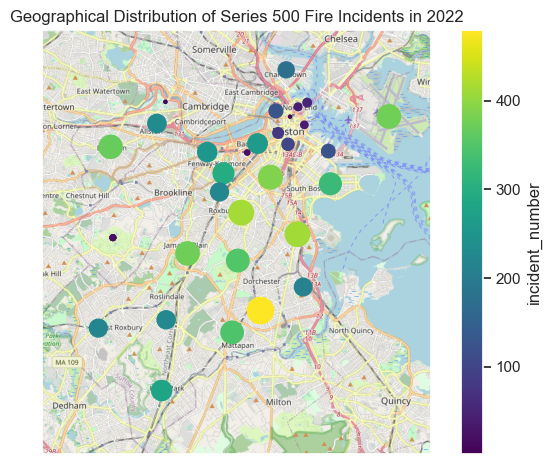

In [305]:
# # count employees per zip code
Series_500 = data[data.incident_type < 500]

zip_count = Series_500[Series_500.year == 2022]\
                .groupby('zip')\
                .agg(np.size)\
                .reset_index()\
                # .rename(columns={'incident_suffix': 'incident_num'})
zip_df = pd.merge(zip_count, zll, on='zip', how='inner')

# generate various zip code maps
boston_500 = pd.merge(zip_df, boston, on='zip', how='inner')
suburbs = zip_df[~zip_df['zip'].isin(boston['zip'])]

fig = plt.figure()
ax = plt.axes( projection= osm_tiles.crs)

# define map range (city of Boston)
img_extent = (-71.19, -70.985, 42.395, 42.23)
ax.set_extent(img_extent, ccrs.PlateCarree())

# add map image
ax.add_image(osm_tiles, 12)

# boston data
boston_500.plot('long','lat', kind='scatter', marker='.', s=boston_500['incident_number'].values*3, c='incident_number', cmap=plt.cm.viridis, ax=ax, transform=ccrs.PlateCarree())

ax.set_title('Geographical Distribution of Series 500 Fire Incidents in 2022')
plt.tight_layout()
plt.show()

In [218]:
# Check the column names in the DataFrame
print(boston.columns)


Index(['zip', 'incident_number', 'exposure_number', 'alarm_date', 'alarm_time',
       'incident_type', 'incident_description', 'estimated_property_loss',
       'estimated_content_loss', 'district', 'city_section', 'neighborhood',
       'property_use', 'property_description', 'street_number',
       'street_prefix', 'street_name', 'year', 'lat', 'long'],
      dtype='object')


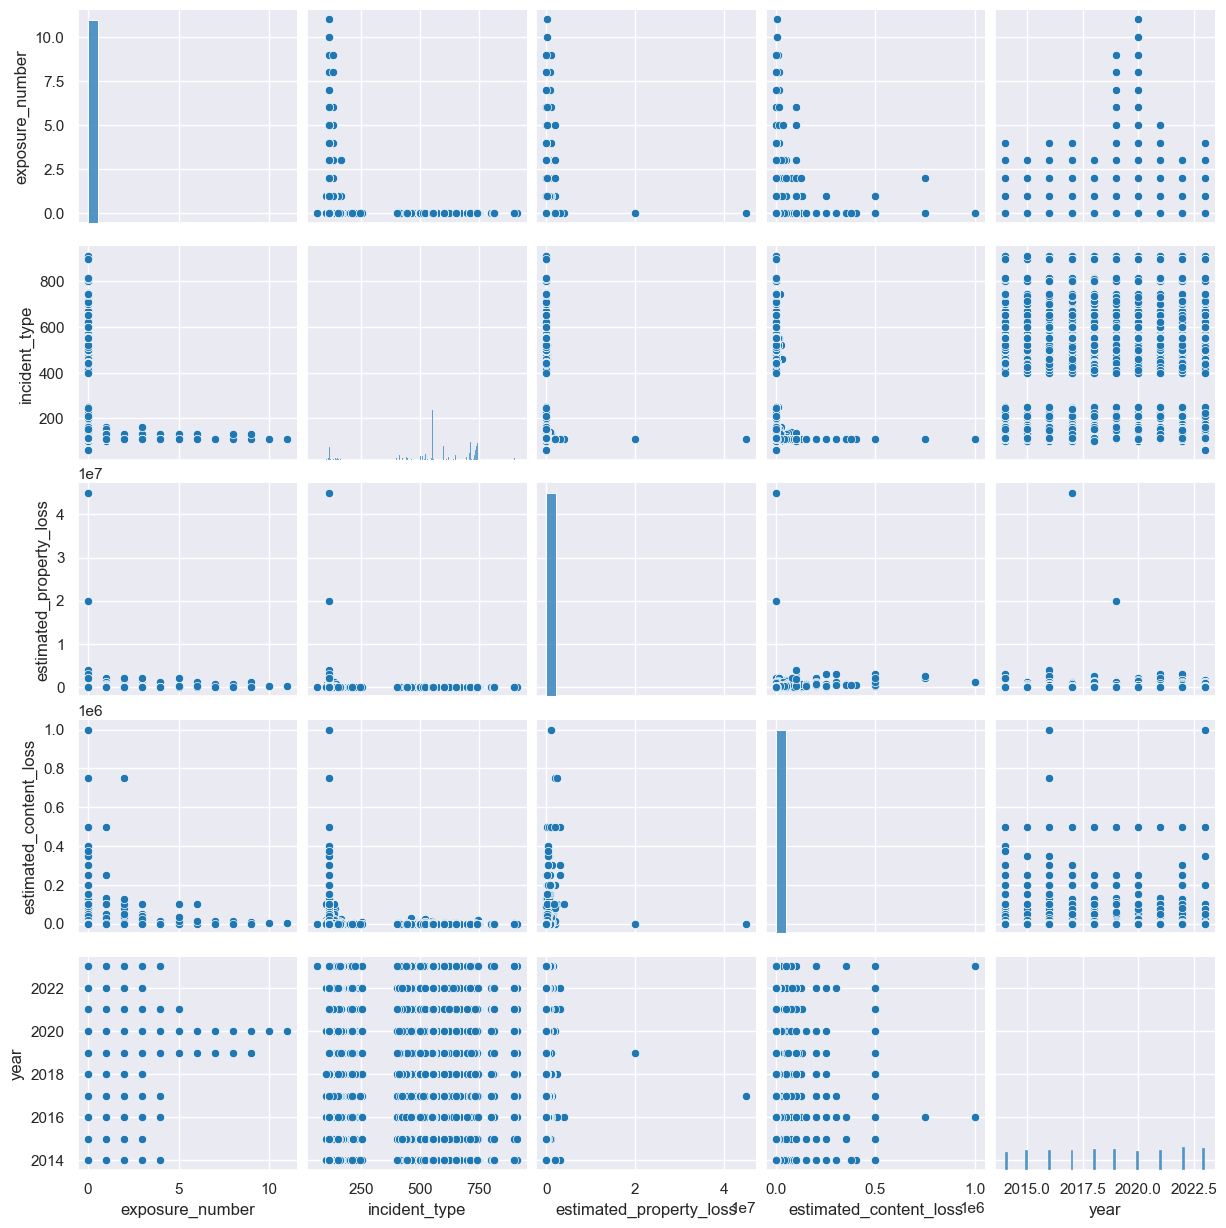

In [219]:
sns.pairplot(data)


In [220]:
# Basic statistical details
print(data.describe())

# # Frequency of different incident types
# incident_freq = data['incident_type'].value_counts()

# # Visualize the incident frequency
# sns.barplot(x=incident_freq.index, y=incident_freq.values)
# plt.title('Frequency of Different Incident Types')
# plt.ylabel('Frequency')
# plt.xlabel('Incident Type')
# plt.xticks(rotation=90)
# plt.show()

       exposure_number  incident_type  estimated_property_loss  \
count    458256.000000  450892.000000             4.582560e+05   
mean          0.001021     570.237418             8.653117e+02   
std           0.058561     185.176608             7.612029e+04   
min           0.000000      61.000000             0.000000e+00   
25%           0.000000     550.000000             0.000000e+00   
50%           0.000000     554.000000             0.000000e+00   
75%           0.000000     715.000000             0.000000e+00   
max          11.000000     911.000000             4.500000e+07   

       estimated_content_loss           year  
count           458256.000000  458256.000000  
mean               147.949279    2018.645017  
std               5131.646765       2.864296  
min                  0.000000    2014.000000  
25%                  0.000000    2016.000000  
50%                  0.000000    2019.000000  
75%                  0.000000    2021.000000  
max            1000000.000000

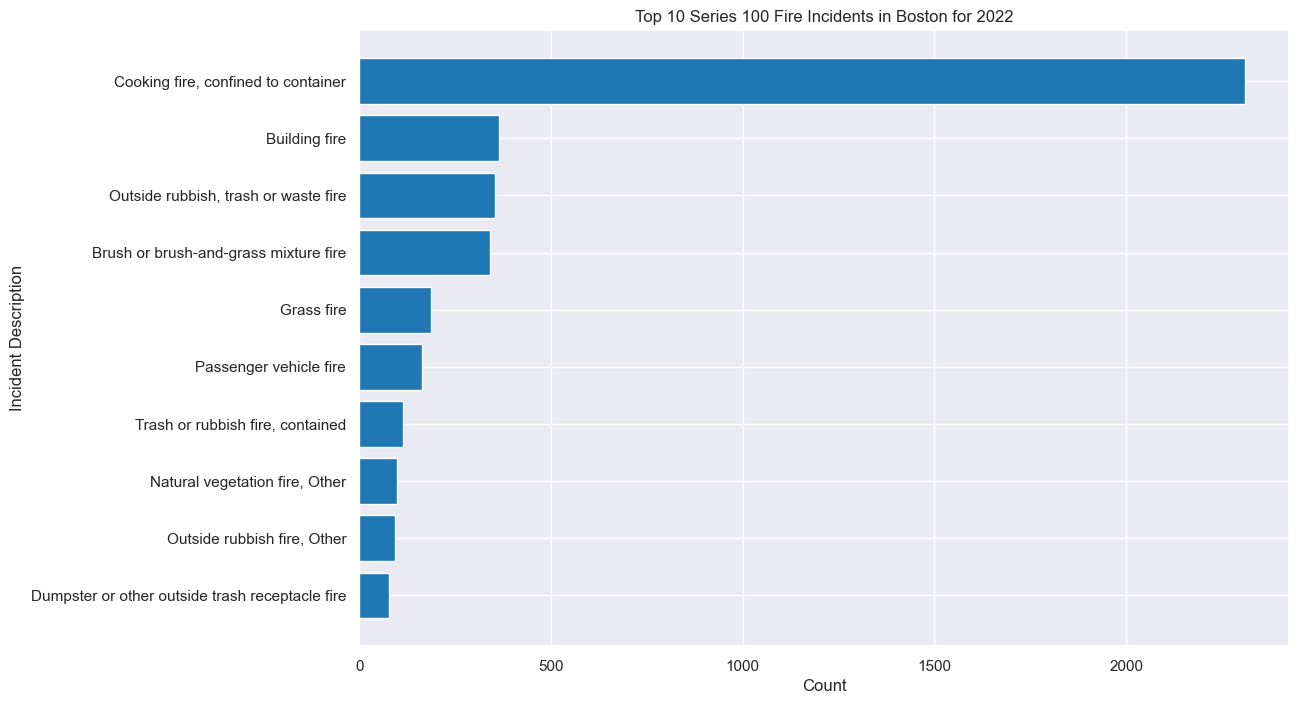

In [320]:

# Filter for the year 2022 and Boston location
boston_100_2022 = Series_100[(Series_100['year'] == 2022) & (Series_100['zip'].isin(boston['zip']))]

# Group by 'incident_type' and 'incident_description' and count occurrences for Boston 2022
incident_counts_boston_100_2022 = boston_100_2022.groupby(['incident_type', 'incident_description']).size()

# Get the top 10 incidents for Boston 100 in 2022
top_10_incidents_boston_100_2022 = incident_counts_boston_100_2022.nlargest(10).reset_index(name='count')

# Create a bar chart for the top 10 incidents of Boston 100 in 2022
plt.figure(figsize=(12, 8))
plt.barh(top_10_incidents_boston_100_2022['incident_description'], top_10_incidents_boston_100_2022['count'])
plt.xlabel('Count')
plt.ylabel('Incident Description')
plt.title('Top 10 Series 100 Fire Incidents in Boston for 2022')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest count on top
plt.show()


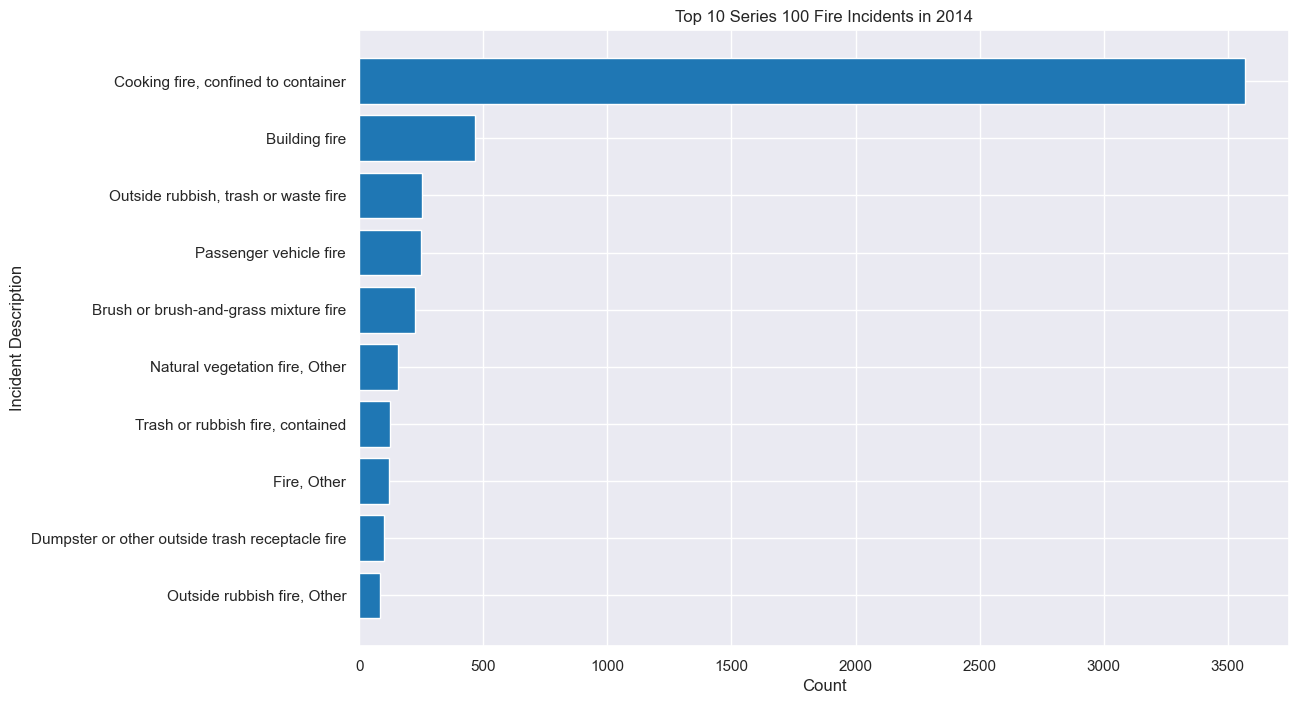

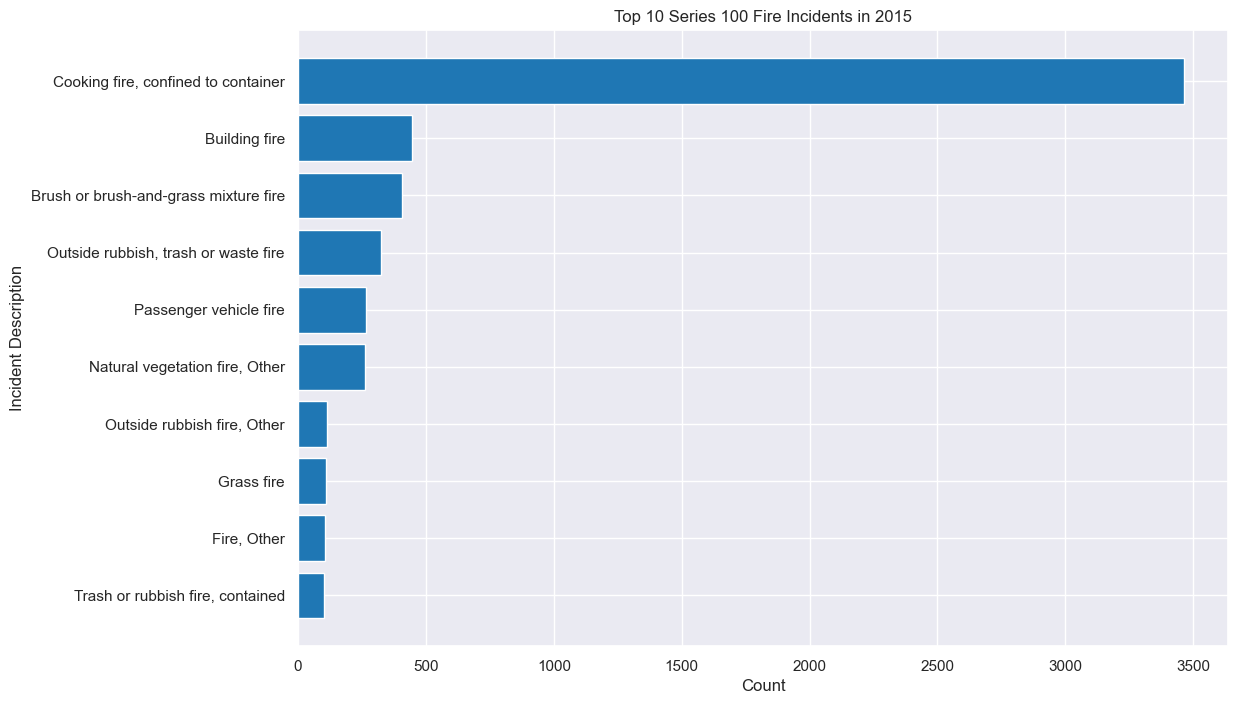

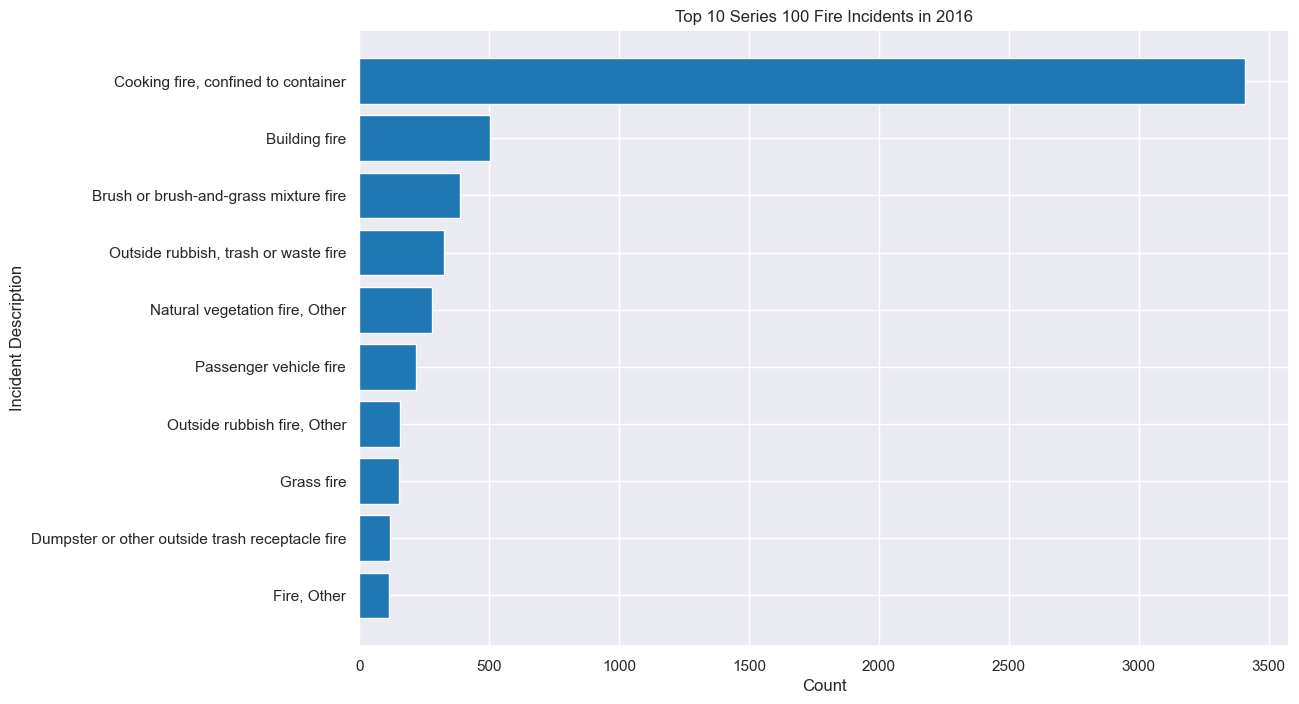

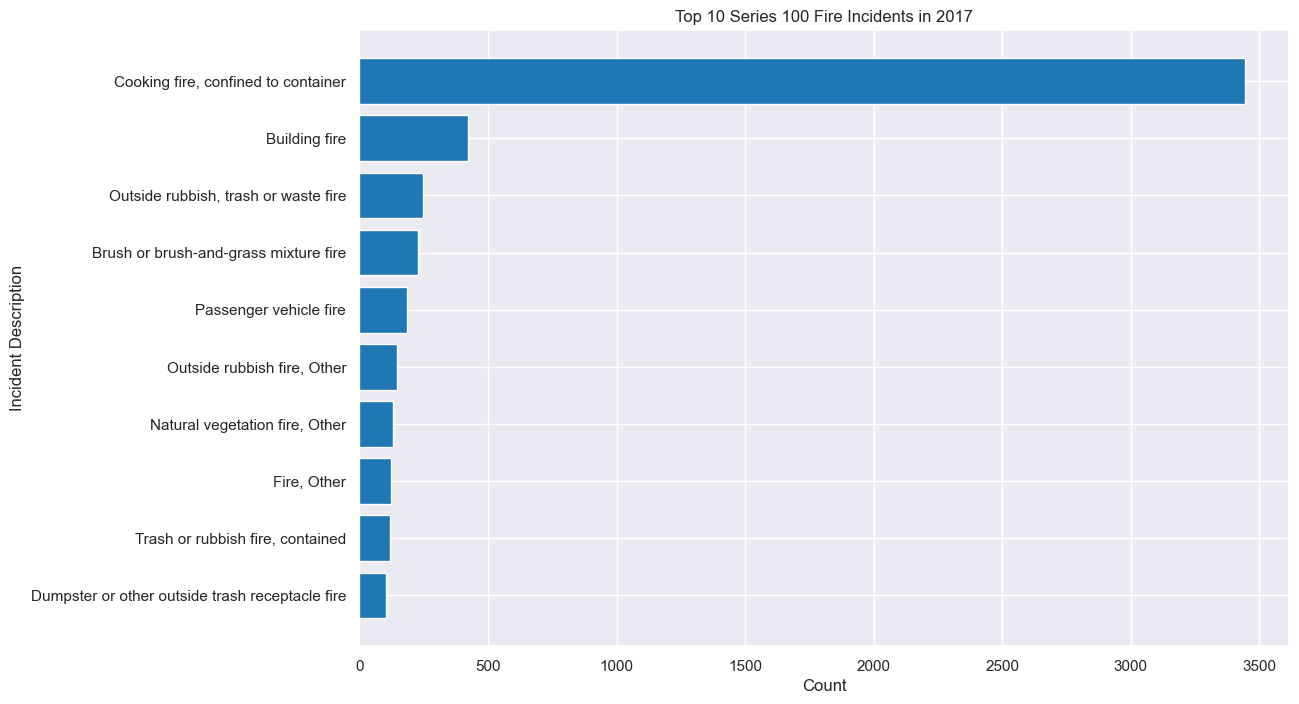

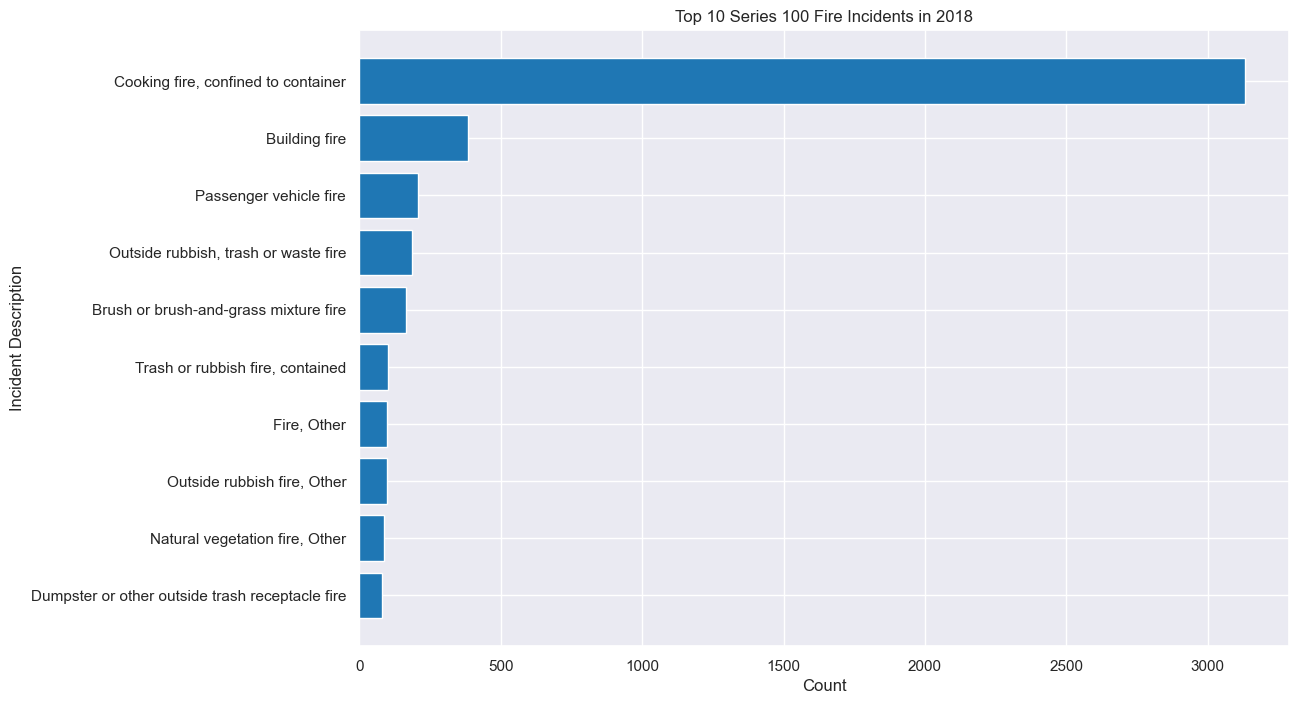

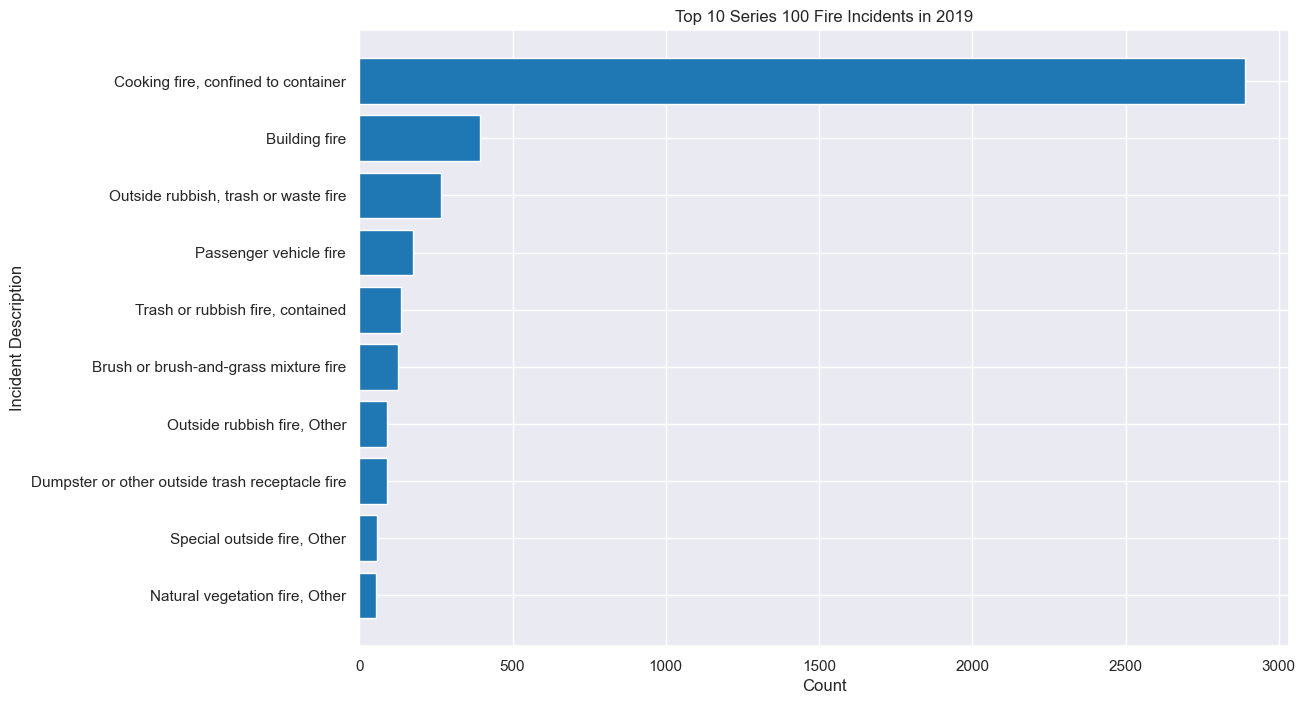

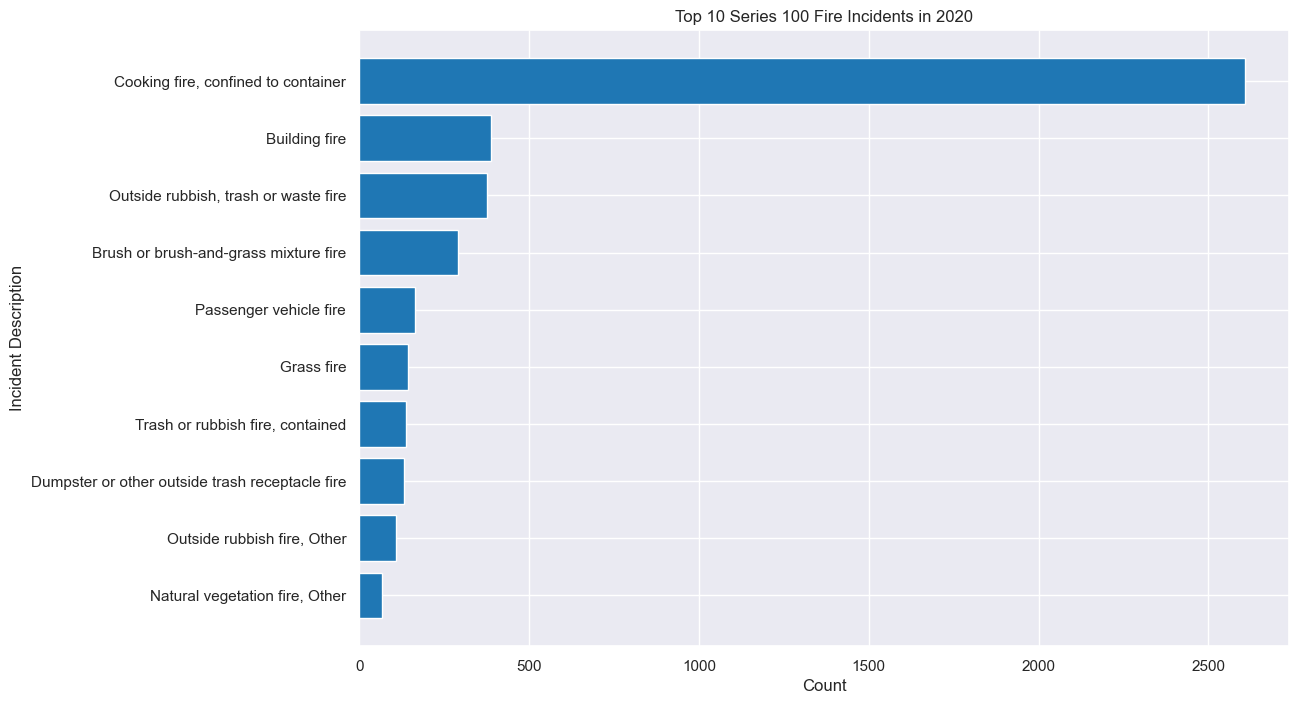

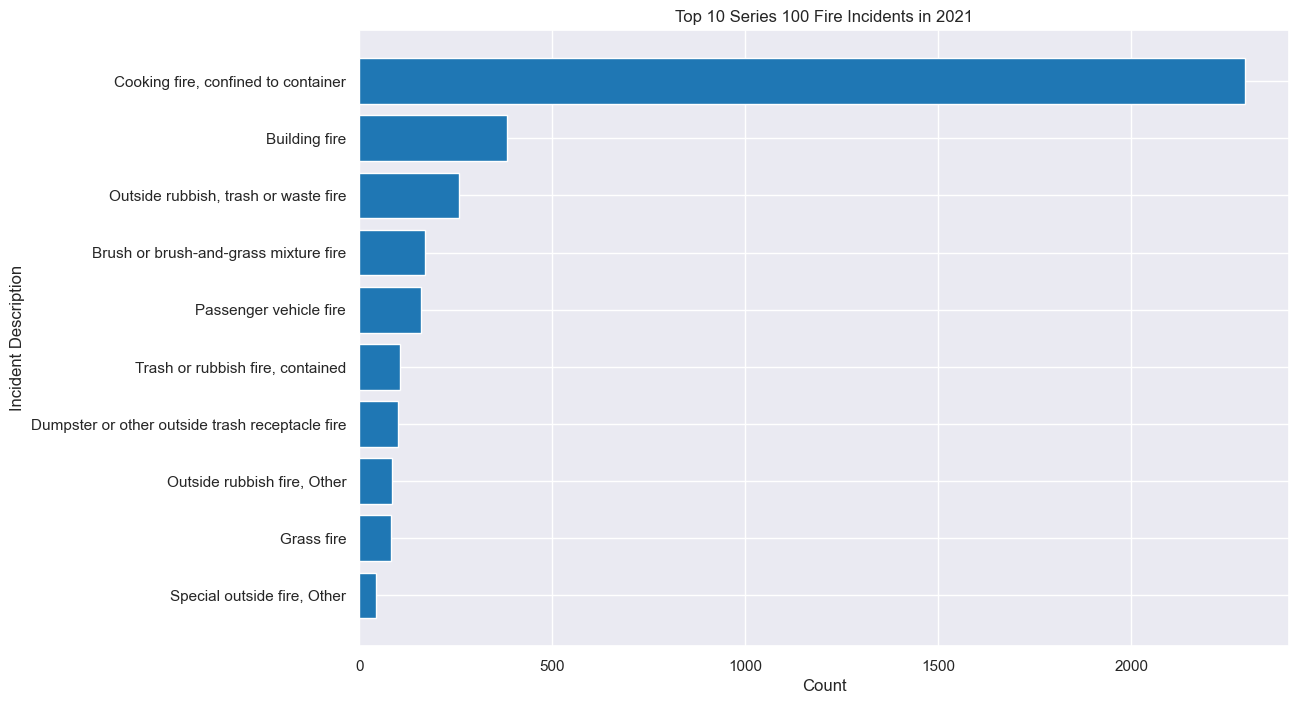

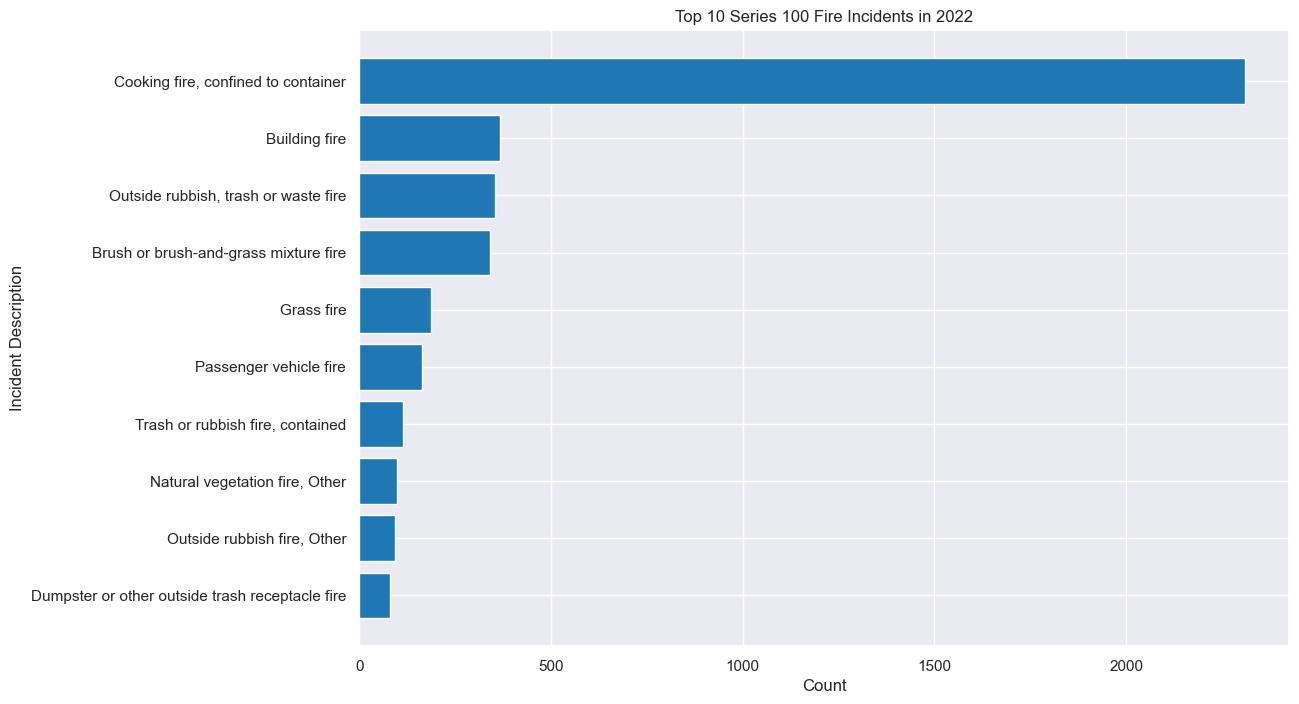

In [322]:
# Filter the data for years 2014 to 2022
filtered_data_2014_to_2022 = data[(data['year'] >= 2014) & (data['year'] <= 2022) & (data['incident_type'] < 200)]

# Group by 'year' and 'incident_description' and count occurrences
incident_counts_by_year = filtered_data_2014_to_2022.groupby(['year', 'incident_description']).size().reset_index(name='count')

# Sort the data for better visualization
sorted_incident_counts_by_year = incident_counts_by_year.sort_values(['year', 'count'], ascending=[True, False])

# Now we can plot this data. If we want to see the top incidents for each year separately:
for year in range(2014, 2023):
    yearly_data = sorted_incident_counts_by_year[sorted_incident_counts_by_year['year'] == year]
    top_10_yearly = yearly_data.nlargest(10, 'count')
    
    plt.figure(figsize=(12, 8))
    plt.barh(top_10_yearly['incident_description'], top_10_yearly['count'])
    plt.xlabel('Count')
    plt.ylabel('Incident Description')
    plt.title(f'Top 10 Series 100 Fire Incidents in {year}')
    plt.gca().invert_yaxis()  # Invert y-axis to have the highest count on top
    plt.show()


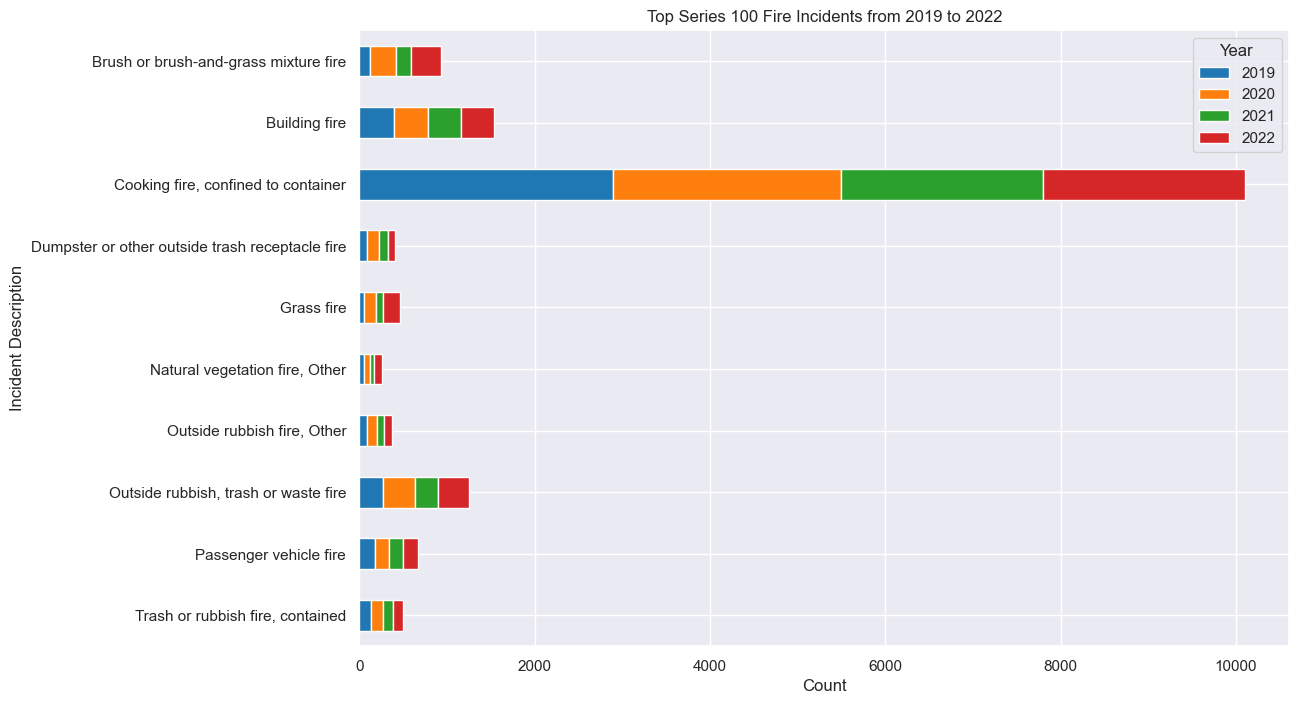

In [323]:
# Filter the data for years 2019 to 2022
filtered_data_2019_to_2022 = data[(data['year'] >= 2019) & (data['year'] <= 2022) & (data['incident_type'] < 200)]

# Group by 'incident_description' and 'year', then count occurrences
incident_counts = filtered_data_2019_to_2022.groupby(['incident_description', 'year']).size().reset_index(name='count')

# Get the top incidents across all years
top_incidents_overall = incident_counts.groupby('incident_description')['count'].sum().nlargest(10).index

# Filter out the top incidents
top_incidents_by_year = incident_counts[incident_counts['incident_description'].isin(top_incidents_overall)]

# Pivot the data for plotting
pivot_df = top_incidents_by_year.pivot(index='incident_description', columns='year', values='count').fillna(0)

# Plot a stacked bar chart
pivot_df.plot(kind='barh', stacked=True, figsize=(12, 8))

plt.xlabel('Count')
plt.ylabel('Incident Description')
plt.title('Top Series 100 Fire Incidents from 2019 to 2022')
plt.legend(title='Year')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest count on top
plt.show()


In [221]:
import matplotlib.pyplot as plt


   incident_type                               incident_description  count
0          553.0                                     Public service  58830
1          745.0   Alarm system activation, no fire - unintentional  22671
2          714.0             Central station, malicious false alarm  18897
3          600.0                            Good intent call, Other  18896
4          743.0  Smoke detector activation, no fire - unintenti...  16092
5          113.0                Cooking fire, confined to container  15063
6          735.0            Alarm system sounded due to malfunction  10884
7          554.0                                     Assist invalid  10506
8          522.0                                Water or steam leak   7140
9          715.0          Local alarm system, malicious false alarm   6288


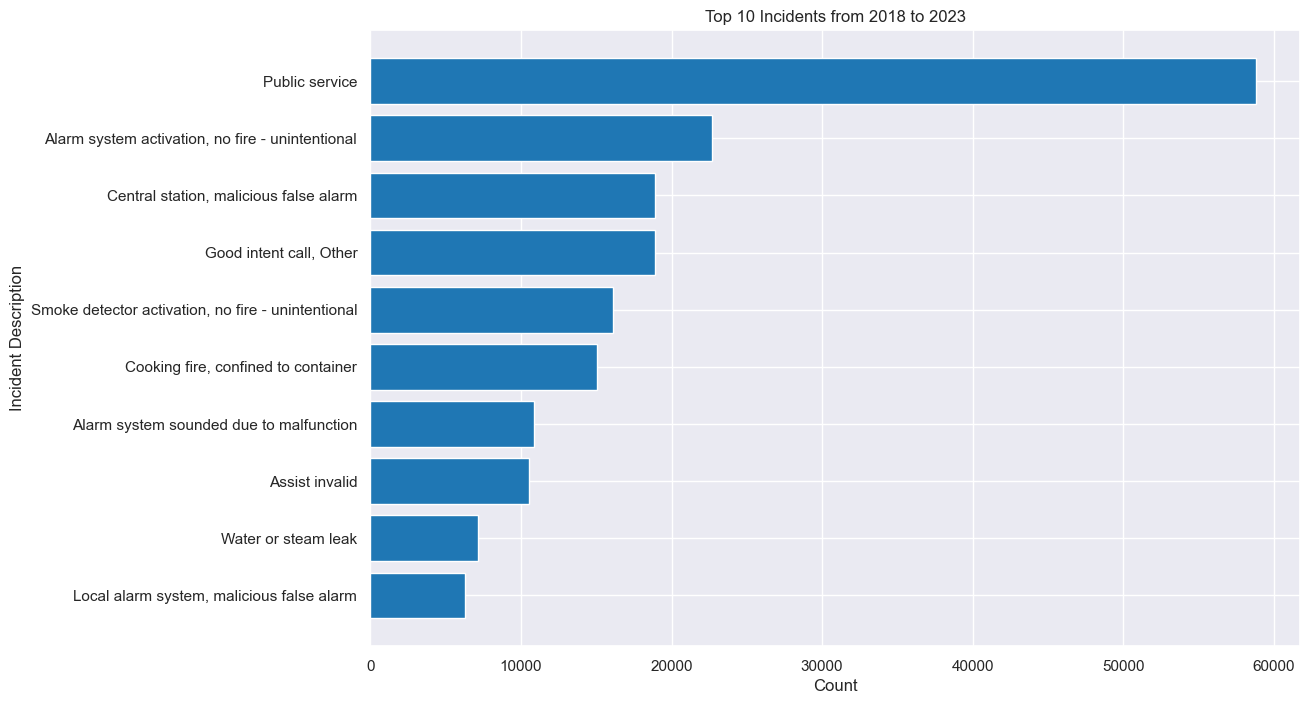

In [222]:
# Filter for years 2018 to 2023
#Group the data by 'incident_type' and 'incident_description' and count the occurrences.
#Display the top 10 incidents overall

filtered_data = data[(data['year'] >= 2018) & (data['year'] <= 2023)]

# Group by 'incident_type' and 'incident_description' and count occurrences
incident_counts = filtered_data.groupby(['incident_type', 'incident_description']).size()

# Get the top 10 incidents
top_10_incidents = incident_counts.nlargest(10).reset_index(name='count')
print(top_10_incidents)

# Create a bar chart
plt.figure(figsize=(12, 8))
plt.barh(top_10_incidents['incident_description'], top_10_incidents['count'])
plt.xlabel('Count')
plt.ylabel('Incident Description')
plt.title('Top 10 Incidents from 2018 to 2023')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest count on top
plt.show()

In [225]:
# Check the data type of the 'year' column
print(data['year'].dtype)

# Check the unique values in the 'year' column
print(data['year'].unique())

# Check for any particular year if data is present
print(data[data['year'] == 2015].head())


int64
[2023 2022 2021 2020 2019 2018 2017 2016 2015 2014]
       incident_number  exposure_number alarm_date alarm_time  incident_type  \
392417      15-0082261                0 2015-12-31   00:11:27          424.0   
392418      15-0082263                0 2015-12-31   00:14:52          652.0   
392419      15-0082264                0 2015-12-31   00:21:36          735.0   
392420      15-0082265                0 2015-12-31   00:27:35          424.0   
392421      15-0082266                0 2015-12-31   00:30:06          736.0   

                                 incident_description  \
392417                       Carbon monoxide incident   
392418  Steam, vapor, fog or dust thought to be smoke   
392419        Alarm system sounded due to malfunction   
392420                       Carbon monoxide incident   
392421      CO detector activation due to malfunction   

        estimated_property_loss  estimated_content_loss district city_section  \
392417                        0      

In [230]:
from numpy.polynomial.polynomial import polyfit


In [231]:
# This visualization will show the trend of only those incidents which have increased over the years. If there are fewer than 10 incident types that have increased, the plot will show only those.


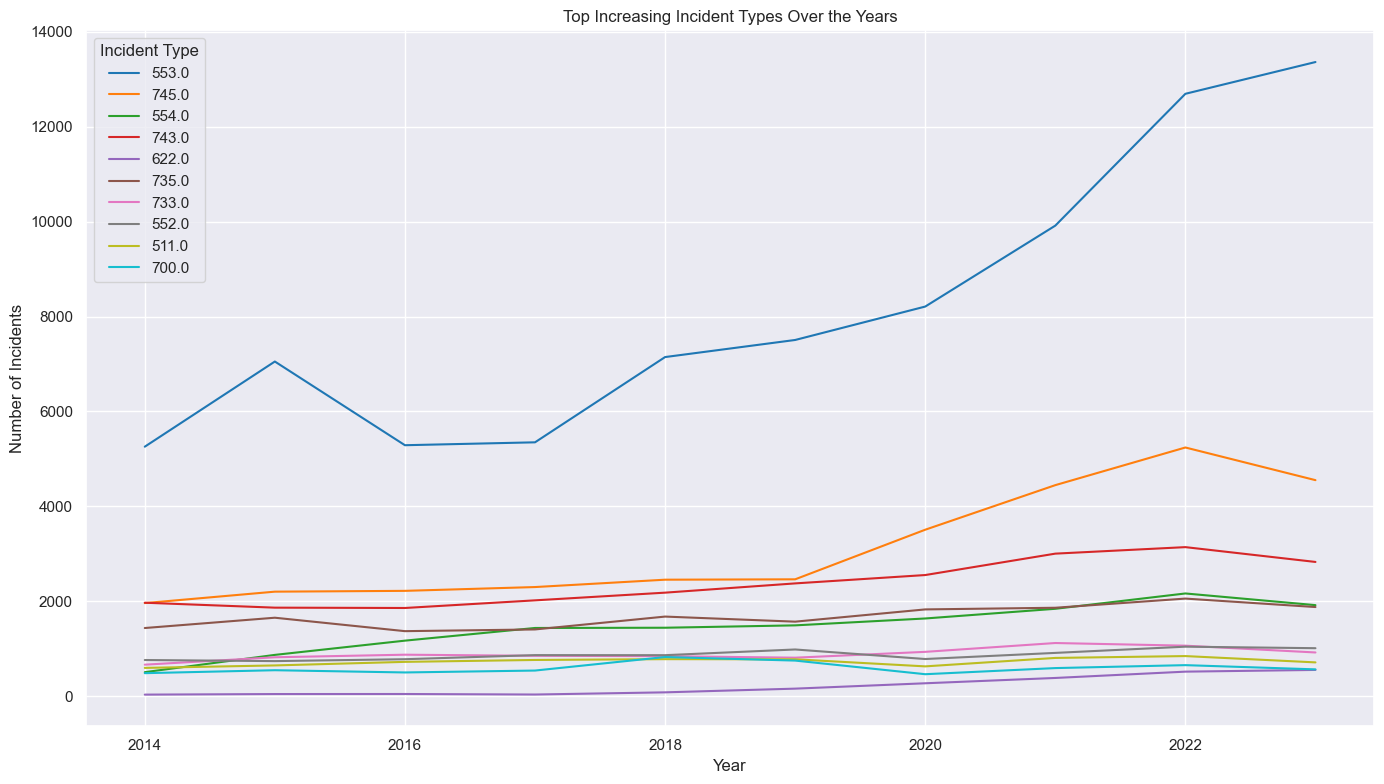

In [232]:
# Group by 'incident_type' and 'year' and count occurrences
incident_counts = data.groupby(['incident_type', 'year']).size().reset_index(name='count')

# Pivot to have years on the columns and incident types on the rows
pivot_table = incident_counts.pivot(index='incident_type', columns='year', values='count').fillna(0)

# Calculate the slope of the trend for each incident type over the years
# Positive slope indicates an increase, negative slope indicates a decrease
slopes = {}
for incident_type in pivot_table.index:
    # Fit a first degree polynomial (linear fit) to the data
    b, m = polyfit(pivot_table.columns, pivot_table.loc[incident_type], 1)
    slopes[incident_type] = m  # Store the slope

# Filter to get only incident types with an increasing trend
increasing_incidents = {k: v for k, v in slopes.items() if v > 0}

# Sort the incidents by slope in descending order to get the most increasing incidents
sorted_increasing_incidents = sorted(increasing_incidents.items(), key=lambda item: item[1], reverse=True)

# Now plot the top 10 increasing incident types
top_10_increasing = sorted_increasing_incidents[:10]
incident_types, _ = zip(*top_10_increasing)  # Unpack the incident types

plt.figure(figsize=(14, 8))
for incident_type in incident_types:
    plt.plot(pivot_table.columns, pivot_table.loc[incident_type], label=incident_type)

plt.xlabel('Year')
plt.ylabel('Number of Incidents')
plt.title('Top Increasing Incident Types Over the Years')
plt.legend(title='Incident Type')
plt.grid(True)
plt.tight_layout()
plt.show()

In [233]:
#categorize the incident_type codes according to their series and subcategories as Following PDF
# https://osfm.fire.ca.gov/media/hqpkkx1u/calstats_incidentcodeguide.pdf

In [234]:
# Assigning category to each department

In [235]:
fire_incident_hierarchy = {
        '111': 'Building Fire',
        '112': 'Fires in structures other than in a building',
        '113': 'Cooking Fire, Confined to Container',
        '114': 'Chimney or Flue Fire, Confined to Chimney or Flue',
        '115': 'Incinerator Overload or Malfunction, Fire Confined',
        '116': 'Fuel Burner/Boiler Malfunction, Fire Confined',
        '117': 'Commercial Compactor Fire, Confined to Rubbish',
        '118': 'Trash or Rubbish Fire, Contained',
        '121': 'Fire in Mobile Home Used as Fixed Residence',
        '122': 'Fire in Motor Home, Camper, Recreational Vehicle',
        '123': 'Fire in Portable Building, Fixed Location',
        '131': 'Passenger Vehicle Fire',
        '132': 'Road freight or transport vehicle Fire',
        '133': 'Rail Vehicle Fire',
        '134': 'Water Vehicle Fire',
        '135': 'Aircraft Fire',  
        '136': 'Self-Propelled Motor Home or Recreational Vehicle Fire',
        '137': ' recreational vehicle',
        '138': 'Off-Road Vehicle or Heavy Equipment Fire',
        '140': 'Natural Vegetation Fire, Other',
        '141': 'Forest, Woods or Wildland Fire',
        '142': 'Brush or Brush-and-Grass Mixture Fire',
        '143': 'Grass Fire',
        '151': 'Outside Rubbish or Trash or Waste Fire',
        '152': 'Garbage Dump or Sanitary Landfill Fire',
        '153': 'Construction or Demolition Landfill Fire',
        '154': 'Dumpster or Other Outside Trash Receptacle Fire',
        '155': 'Outside Stationary Compactor/Compacted Trash Fire',
        '161': 'Outside Storage Fire on Residential or Commercial Property',
        '162': 'Outside Equipment Fire',
        '163': 'Outside Gas or Vapor Combustion Explosion',
        '164': 'Outside Mailbox Fire',
        '171': 'Cultivated Grain or Crop Fire',
        '172': 'Cultivated Orchard or Vineyard Fire',
        '173': 'Cultivated Trees or Nursery Stock Fire',
    },
    
overheat_No_Fire =  {
         '211': 'Overpressure rupture of steam pipe or pipeline',
        '212': 'Overpressure rupture of steam boiler',
         '213': 'Steam rupture of pressure or process vessel',
        '221': ' Overpressure rupture of air or gas pipe/pipeline',
        '222': ' Overpressure rupture of boiler from air or gas',
        '223': ' Air or gas rupture of pressure or process vessel',
        '231': 'Chemical reaction rupture of pressure or process vessel',
        '241': 'Munitions or bomb explosions',
        '242': 'Blasting agent explosion ',
        '243': 'Fireworks explosion ',
        '244': 'Dust explosion',
        '251': 'H Excessive heat, scorch burns with no ignition',
    },
Rescue_EMS_Incidents =  {
        '311': 'Medical assist',
        '321': 'EMS call, excluding vehicle accident with injury',
        '322': 'Motor vehicle accident with injuries',
        '323': 'Motor vehicle/pedestrian accident (MV Ped)',
        '324': 'Motor vehicle accident with no injuries',
        '341': 'Search for person on land',
        '342': 'Search for person on water',
        '343': 'Search for person underground',

        '351': 'Extrication of victim(s) from building/structure',
        '352': 'Extrication of victim(s) from vehicle',
        '353': ' Removal of victim(s) from stalled elevator',
        '354': '  Trench/below grade rescue',
        '355': 'confined space resue ',
        '356': 'High angle rescue',
        '357': '  Extrication of victim(s) from machinery',

        '361': 'Water and ice-related rescue',
        '362': 'Ice rescue',
        '363': 'Swift water rescue',
        '364': 'Surf rescue',
        '365': 'Watercraft rescue',

        '371': 'Electrical rescue',
        '372': 'Elevator rescue',
        '381': 'Rescue or EMS standby',
    }
Hazardous_Condition_No_Fire =  {
        '411': 'Gasoline or other flammable liquid spill',
        '412': 'Gas leak (natural gas or LPG)',
        '413': 'Oil or other combustible liquid spill',
   
        '421': 'Chemical release, reaction, or toxic condition, other',
        '422': 'Chemical spill or leak',
        '423': ' Refrigeration leak',
        '424': ' Carbon monoxide incident',
   
        '431': 'Radiation leak, radioactive material',

        '441': ' Heat from short circuit (wiring), defective/worn',
        '442': ' Overheated motor or wiring',
        '443': ' Breakdown of light ballast',
        '444': ' Power line down',
        '445': ' Arcing, shorted electrical equipment',
        '451': 'Biological hazard, confirmed or suspected',
   
        '461': ' Building or structure weakened or collapsed',
        '462': ' Aircraft standby',
        '463': ' Vehicle accident, general cleanup',
       '471': '  Explosive, bomb removal ',
       '481': '  Attempt to burn',
        '482': ' Threat to burn',
   },
Series_500 =  {
   
        '511': 'Lock-out',
        '512': 'Ring or jewelry removal',
  
        '521': 'Water evacuation',
        '522': 'Water or steam leak',
  
        '531': 'Smoke or odor removal',
  
        '541': 'Animal problem',
        '542': 'Animal rescue',
   
        '551': 'Assist police or other governmental agency',
        '552': 'Public matter',
         '553': 'Public service assistance, other',
        '554': 'Assist invalid',
       '555': 'Defective elevator, no occupants',
   
        '561': 'Unauthorized burning',
        '571': ' Cover assignment, standby, moveup',

    },
Series_600 =  {
    
        '611': 'Dispatched & canceled en route',
 
        '621': 'Wrong location',
        '622': 'No incident found on arrival at dispatch address',
 
        '631': 'Authorized controlled burning',
        '632': 'Prescribed ÿre (with prior written, approved fire plan)',
 
        '641': 'Vicinity alarm (nothing found)',
   
        '651': 'Smoke scare, odor of smoke',
        '652': 'Steam, vapor, fog or dust thought to be smoke',
        '653': 'Smoke from barbecue, tar kettle ',
  
        '661': 'EMS call, party transported by non-fire agency',
 
        '671': 'Detonation, explosion (no fire)',
        '672': ' Biological hazard, none found',
    },

Series_700 = {
   
        '711': 'Municipal alarm system, malicious false alarm',
        '712': ' Direct tie to FD, malicious/false alarm',
        '713': 'Telephone, malicious false alarm',
        '714': 'Central station, malicious false alarm',
       '715': ' Local alarm system, malicious false alarm',
     '721': '  Bomb scare - no bomb',
  
        '731': 'Sprinkler activation due to malfunction',
        '732': 'Extinguishing system activation due to malfunction',
        '733': 'Smoke detector activation due to malfunction',
        '734': ' Heat detector activation due to malfunction',
        '735': 'Alarm system sounded due to malfunction',
        '736': 'CO detector activation due to malfunction',

   
        '741': 'Sprinkler activation, no ÿre - unintentional',
        '742': 'Extinguishing system activation',
        '743': 'Smoke detector activation, no fire - unintentional',
        '744': 'Heat detector activation, no fire - unintentional',
        '745': 'Carbon monoxide detector activation, no fire - unintentional',
        '746': 'Carbon monoxide detector activation, no CO',
        '751': 'Biological hazard, malicious false report'
        },
   
Series_800 =  {
        '811': 'Earthquake assessment',
        '812': 'Flood assessment',
        '813': 'Wind storm, tornado/hurricane assessment',
        '814': ' Lightning strike (no fire), includes investigation',
        '815': 'Severe weather or natural disaster standby',
        '911': 'Citizen complaint'
    }



In [236]:
# Function to map incident codes to their descriptions
def map_incident_codes(df, hierarchy):
    # Create new columns for the main category and subcategory descriptions
    df['Category_Description'] = ''
    df['Subcategory_Description'] = ''
    
    # Iterate over the hierarchy to map codes to descriptions
    for series, incidents in hierarchy.items():
        series_code = series.split(' ')[0]  # e.g., '100' from '100 Series (Fire)'
        for code, description in incidents.items():
            # Filter dataframe rows where incident type matches the code and update descriptions
            if str(df['incident_type']).startswith(series_code):
                df.loc[df['incident_type'] == int(code), 'Category_Description'] = series
                df.loc[df['incident_type'] == int(code), 'Subcategory_Description'] = description
            
    return df

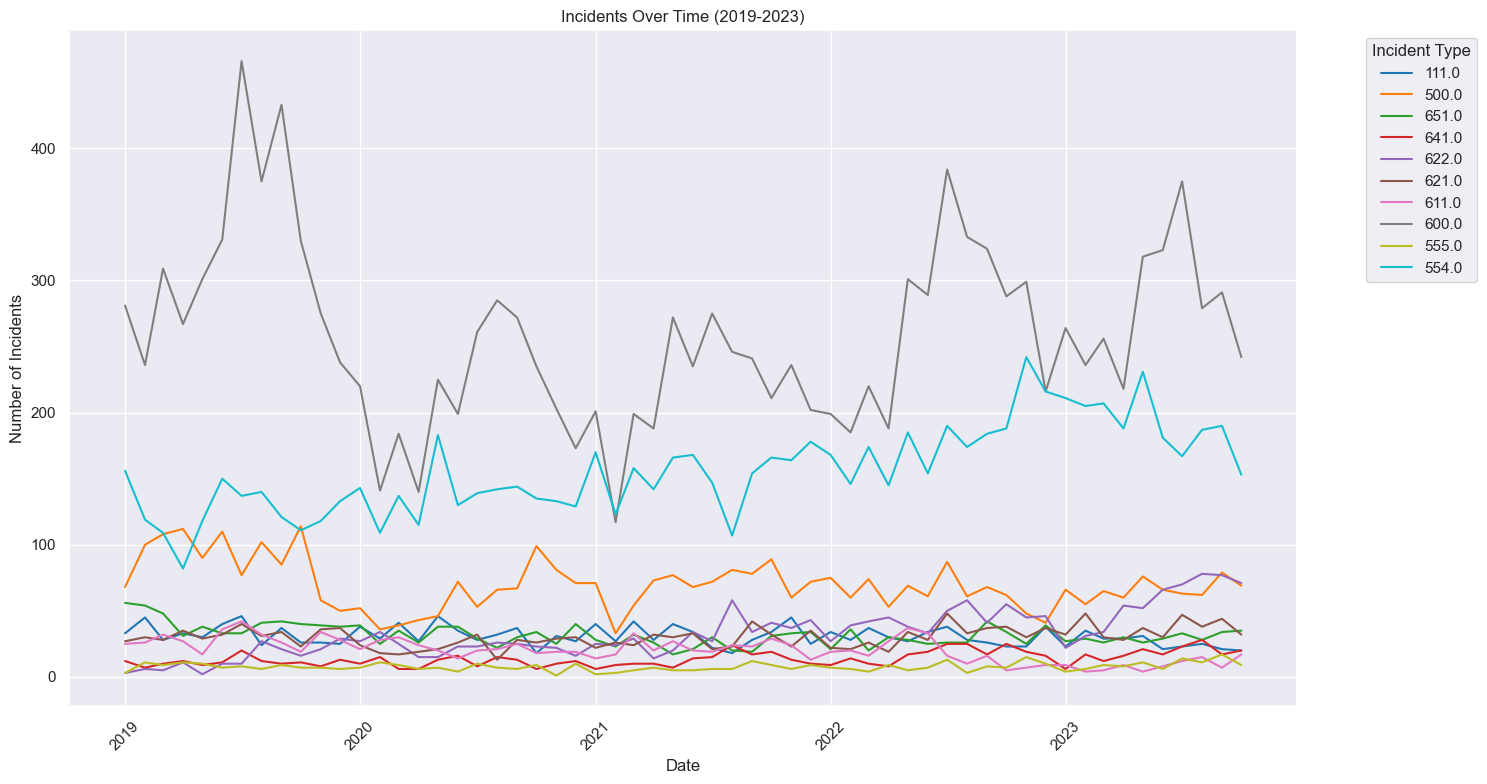

In [237]:
# Filter the dataset for incidents that occurred from 2019 to 2024
filtered_data = data[(data['alarm_date'].dt.year >= 2019) & (data['alarm_date'].dt.year <= 2023)]

# Group by alarm_date at a monthly frequency and incident_type, and count the occurrences
incident_counts = filtered_data.groupby([filtered_data['alarm_date'].dt.to_period('M'), 'incident_type']).size().reset_index(name='counts')

# Convert the 'alarm_date' from Period to datetime for plotting
incident_counts['alarm_date'] = incident_counts['alarm_date'].dt.to_timestamp()

# Pivot the table to have dates as rows and incident types as columns
pivot_table = incident_counts.pivot(index='alarm_date', columns='incident_type', values='counts').fillna(0)

# Plotting
plt.figure(figsize=(15, 8))

# Since there can be many incident types, we might plot the top N incident types for clarity
top_incident_types = incident_counts['incident_type'].value_counts().index[:10]  # Get the top 10 incident types

# Plot a line for each of the top incident types
for incident_type in top_incident_types:
    if incident_type in pivot_table.columns:
        plt.plot(pivot_table.index, pivot_table[incident_type], label=str(incident_type))

plt.xlabel('Date')
plt.ylabel('Number of Incidents')
plt.title('Incidents Over Time (2019-2023)')
plt.legend(title='Incident Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust spacing to fit labels and title
plt.show()

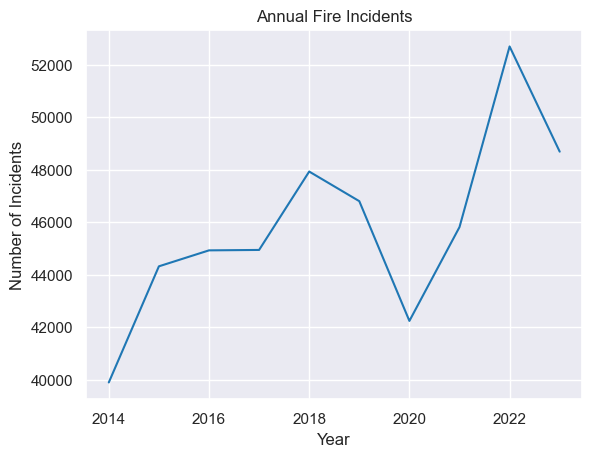

In [238]:
# Number of incidents per year
annual_incidents = data.groupby('year').size()

plt.plot(annual_incidents)
plt.title('Annual Fire Incidents')
plt.xlabel('Year')
plt.ylabel('Number of Incidents')
plt.show()


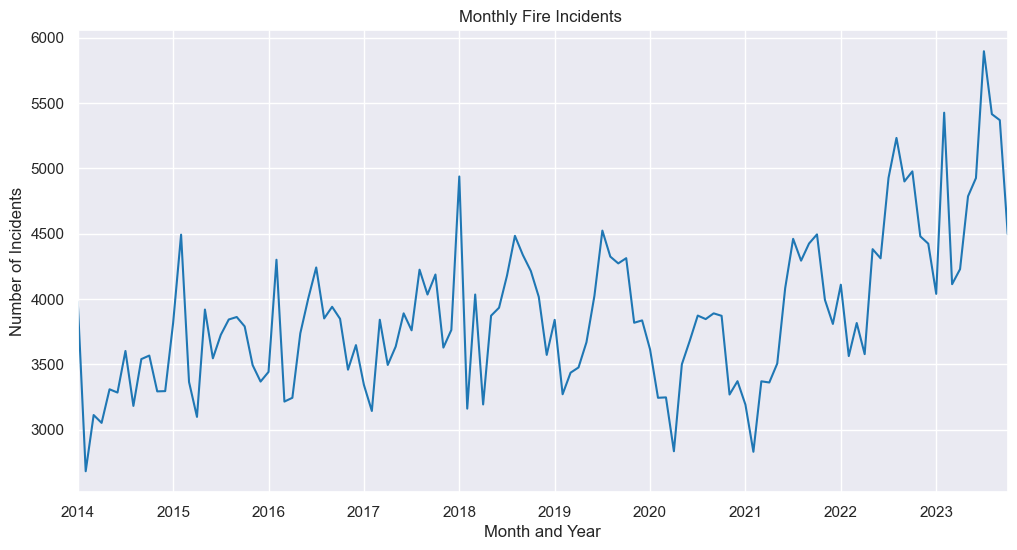

In [306]:
# Time Series of Incidents:



import matplotlib.pyplot as plt

# Assuming 'alarm_date' has been converted to datetime
data['month_year'] = data['alarm_date'].dt.to_period('M')
monthly_incidents = data.groupby('month_year').size()

plt.figure(figsize=(12, 6))
monthly_incidents.plot(title='Monthly Fire Incidents ')
plt.xlabel('Month and Year')
plt.ylabel('Number of Incidents')
plt.show()


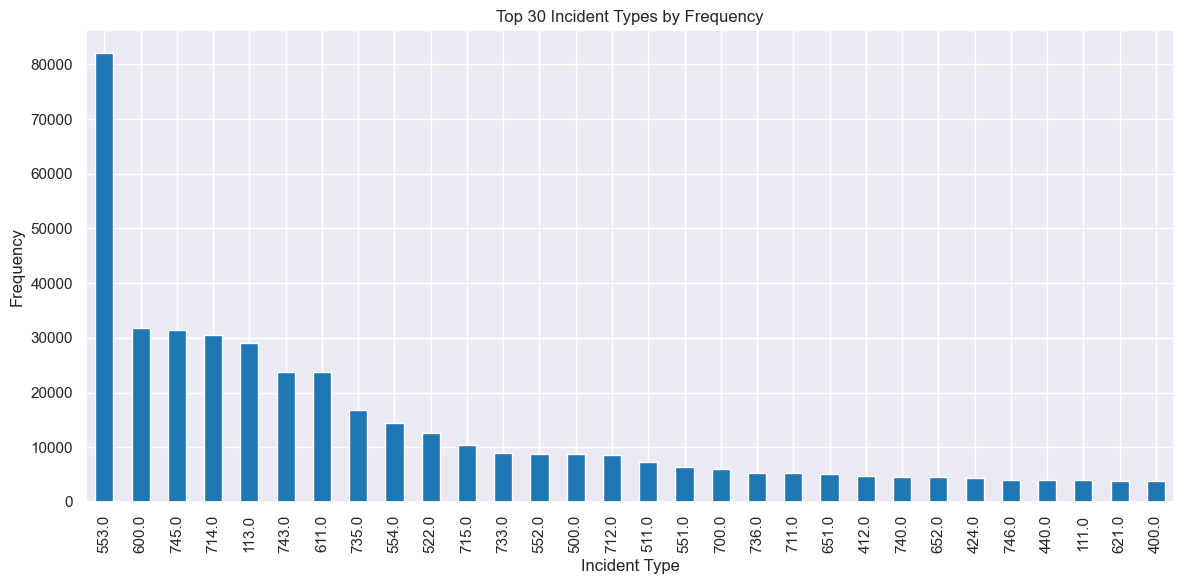

In [241]:
#Bar Chart of Incident Types:
# Select the top 30 incident types
top_30_incident_types = incident_type_counts.head(30)

# Create a bar plot for the top 30 incident types
plt.figure(figsize=(12, 6))
top_30_incident_types.plot(kind='bar')
plt.title('Top 30 Incident Types by Frequency')
plt.xlabel('Incident Type')
plt.ylabel('Frequency')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to fit the x-axis labels
plt.show()


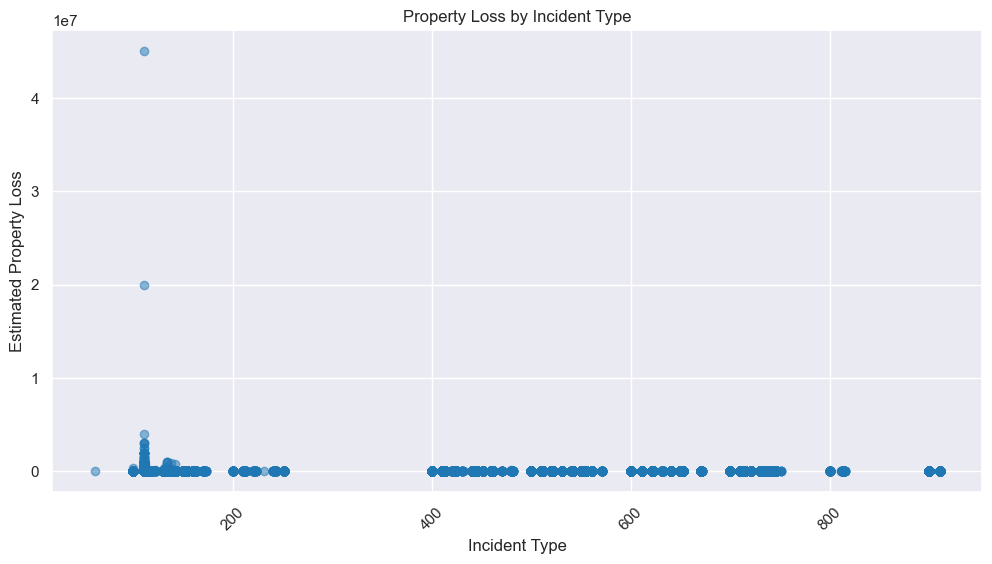

In [242]:
# Scatter Plot of Property Loss:

plt.figure(figsize=(12, 6))
plt.scatter(data['incident_type'], data['estimated_property_loss'], alpha=0.5)
plt.title('Property Loss by Incident Type')
plt.xlabel('Incident Type')
plt.ylabel('Estimated Property Loss')
plt.xticks(rotation=45)
plt.show()


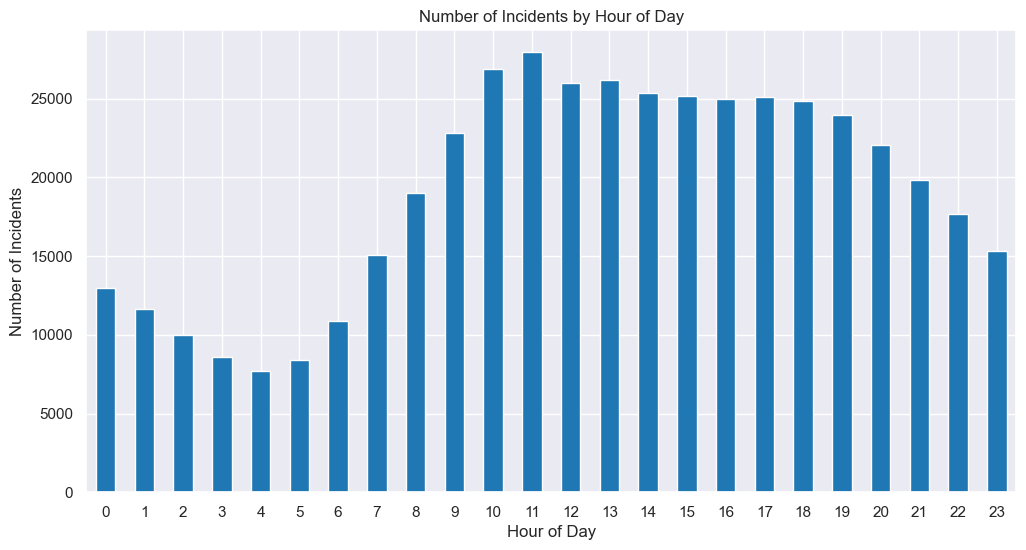

In [243]:
# Extract hour from 'alarm_time'
data['hour'] = pd.to_datetime(data['alarm_time'].astype(str)).dt.hour

# Count the number of incidents for each hour
hourly_incidents = data.groupby('hour').size()

# Plot
plt.figure(figsize=(12, 6))
hourly_incidents.plot(kind='bar')
plt.title('Number of Incidents by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Incidents')
plt.xticks(range(0, 24), rotation=0)  # Ensure x-ticks are for each hour of the day
plt.show()

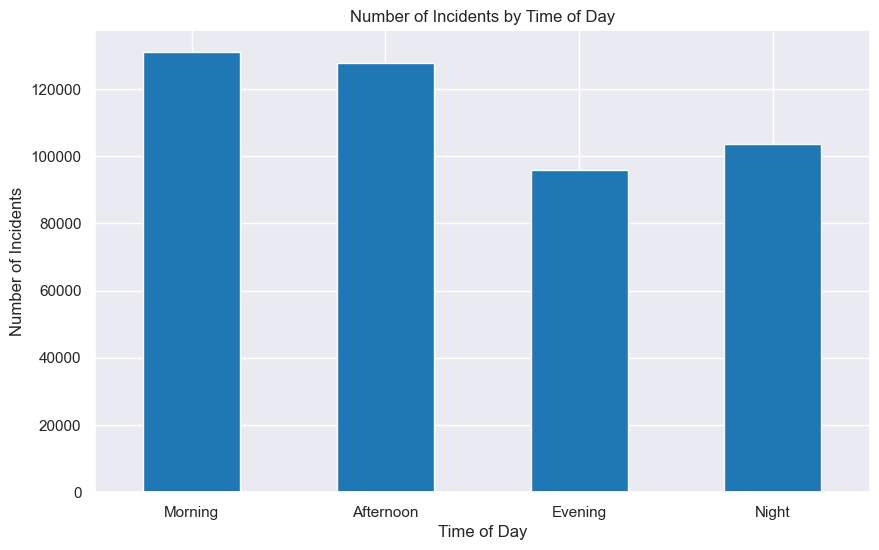

In [244]:
# Number of Incidents by Time of Day
# Define a function to categorize the time of day
def get_time_of_day(hour):
    if 5 <= hour <= 11:
        return 'Morning'
    elif 12 <= hour <= 16:
        return 'Afternoon'
    elif 17 <= hour <= 20:
        return 'Evening'
    else:
        return 'Night'

# Apply the function to the 'hour' column to create a new 'time_of_day' column
data['hour'] = pd.to_datetime(data['alarm_time'].astype(str)).dt.hour
data['time_of_day'] = data['hour'].apply(get_time_of_day)

# Group by 'time_of_day' and count the number of incidents
time_of_day_counts = data['time_of_day'].value_counts()

# Plot
plt.figure(figsize=(10, 6))
time_of_day_counts.reindex(["Morning", "Afternoon", "Evening", "Night"]).plot(kind='bar')
plt.title('Number of Incidents by Time of Day')
plt.xlabel('Time of Day')
plt.ylabel('Number of Incidents')
plt.xticks(rotation=0)  # Horizontal x-ticks for better readability
plt.show()

In [245]:
# run only once 
pip install prophet


SyntaxError: invalid syntax (661523307.py, line 2)

In [255]:
# from prophet import Prophet

# # Aggregate your data to monthly incidents
# monthly_data = data.resample('M', on='alarm_date').size().reset_index(name='incident_count')

# # Rename the columns for Prophet compatibility
# monthly_data.rename(columns={'alarm_date': 'ds', 'incident_count': 'y'}, inplace=True)

# # Initialize the Prophet model
# m = Prophet()

# # Split your data into training and testing sets (e.g., last 12 months as the test set)
# train = monthly_data[:-12]
# test = monthly_data[-12:]

# # Fit the model on the training data
# m.fit(train)

# # Create a DataFrame for future predictions (e.g., next 12 months)
# future = m.make_future_dataframe(periods=12, freq='M')

# # Predict the future incidents
# forecast = m.predict(future)

# # Plot the forecast
# fig1 = m.plot(forecast)


In [256]:
# # Assuming 'forecast' is the dataframe output by the Prophet model after making predictions
# forecast['year'] = forecast['ds'].dt.year  # Add a 'year' column to filter by year

# # Filter the predictions for 2023
# predictions_2023 = forecast[forecast['year'] == 2023]

# # Print the predictions for 2023
# print(predictions_2023[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])


In [247]:
data

,incident_number,exposure_number,alarm_date,alarm_time,incident_type,incident_description,estimated_property_loss,estimated_content_loss,district,city_section,...,zip,property_use,property_description,street_number,street_prefix,street_name,year,month_year,hour,time_of_day
0,23-0079768,0,2023-10-28,00:15:00,511.0,Lock-out,0,0,08,DO,...,02124,429,Multifamily dwelling,1973,NaN,DORCHESTER,2023,2023-10,0,Night
1,23-0079770,0,2023-10-28,00:17:02,552.0,Police matter,0,0,04,BO,...,02111,963,Street or road in commercial area,9,NaN,TYLER,2023,2023-10,0,Night
2,23-0079773,0,2023-10-28,00:34:14,500.0,"Service Call, other",0,0,04,BO,...,02111,900,"Outside or special property, Other",640,NaN,WASHINGTON,2023,2023-10,0,Night
3,23-0079777,0,2023-10-28,01:08:04,553.0,Public service,0,0,03,BO,...,02114,900,"Outside or special property, Other",19,NaN,STANIFORD,2023,2023-10,1,Night
4,23-0079785,0,2023-10-28,01:34:22,553.0,Public service,0,0,11,BR,...,02135,900,"Outside or special property, Other",75,NaN,NONANTUM,2023,2023-10,1,Night
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
458251,14-0000174,0,2014-01-01,22:39:13,746.0,"Carbon monoxide detector activation, no CO",0,0,9,NaN,...,02130,400,"Residential, Other",000022,NaN,GOLDSMITH,2014,2014-01,22,Night
458252,14-0000176,0,2014-01-01,22:53:16,743.0,"Smoke detector activation, no fire - unintenti...",0,0,4,NaN,...,02118,331,Hospital - medical or psychiatric,000840,NaN,HARRISON,2014,2014-01,22,Night
458253,14-0000177,0,2014-01-01,22:58:22,743.0,"Smoke detector activation, no fire - unintenti...",0,0,1,NaN,...,02128,429,Multifamily dwelling,000020,NaN,WALDEMAR,2014,2014-01,22,Night
458254,14-0000180,0,2014-01-01,23:36:43,600.0,"Good intent call, Other",0,0,4,NaN,...,02115,900,"Outside or special property, Other",000255,NaN,MASSACHUSETTS,2014,2014-01,23,Night


20:58:58 - cmdstanpy - INFO - Chain [1] start processing
20:58:58 - cmdstanpy - INFO - Chain [1] done processing


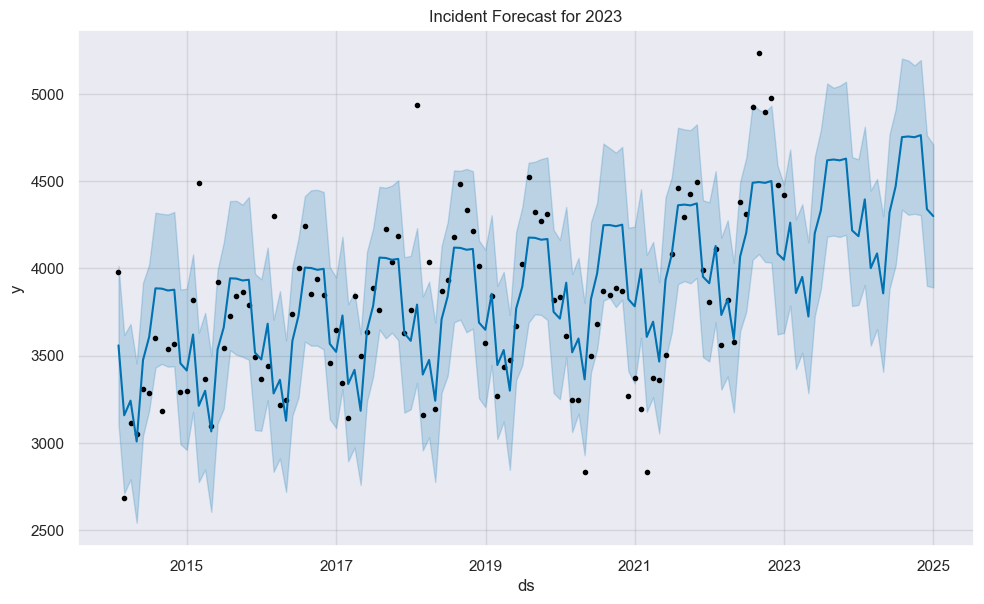

            ds         yhat   yhat_lower   yhat_upper
120 2024-01-31  4395.357319  3904.446320  4812.174511
121 2024-02-29  4001.044987  3556.968917  4446.431163
122 2024-03-31  4085.646129  3652.655314  4512.121187
123 2024-04-30  3856.503816  3406.200713  4299.635881
124 2024-05-31  4320.954837  3882.691582  4767.295131
125 2024-06-30  4471.028043  4018.283618  4911.862643
126 2024-07-31  4752.529599  4337.003374  5202.748839
127 2024-08-31  4756.099846  4307.184164  5192.007124
128 2024-09-30  4751.797224  4312.822995  5163.509101
129 2024-10-31  4763.756369  4304.918924  5194.016609
130 2024-11-30  4339.310508  3899.556459  4762.802693
131 2024-12-31  4299.563927  3890.896828  4710.153431


In [309]:
# same as previous model , just improve varible consistency 
# Drop columns with NaN values in 'property_use' as it's your target variable
data = data.dropna(subset=['property_use'])

# Prepare the data for Prophet
# Aggregate your data to monthly incidents
monthly_data = data.resample('M', on='alarm_date').size().reset_index(name='incident_count')
monthly_data.rename(columns={'alarm_date': 'ds', 'incident_count': 'y'}, inplace=True)

# Filter the data to include only the years up to 2022 for training
train_data = monthly_data[monthly_data['ds'].dt.year < 2023]

# Initialize and fit the Prophet model
m = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
m.fit(train_data)

# Create a DataFrame for future predictions including 2023
future = m.make_future_dataframe(periods=24, freq='M')

# Forecast the future incidents
forecast = m.predict(future)

# Plot the forecast
fig1 = m.plot(forecast)
plt.title('Incident Forecast for 2023')
plt.show()

# Filter the forecast to show only 2023 predictions
forecast_2023 = forecast[(forecast['ds'].dt.year == 2024) & (forecast['ds'].dt.month >= 1)]
print(forecast_2023[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])

In [316]:
test_sub = monthly_data[monthly_data['ds'].dt.year >= 2023]
forecast_sub = forecast[ ['ds', 'yhat' ]]
forecast_sub['ds'] = forecast_sub['ds'].astype(str)
test_sub = test_sub[['ds', 'y']]


/var/folders/3t/kc4zlyzx54l62jhcqlvnbfwr0000gn/T/ipykernel_66509/1526672728.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_sub['ds'] = forecast_sub['ds'].astype(str)


In [318]:
monthly_data

,ds,y
0,2014-01-31,3980
1,2014-02-28,2682
2,2014-03-31,3112
3,2014-04-30,3052
4,2014-05-31,3309
...,...,...
113,2023-06-30,4925
114,2023-07-31,5895
115,2023-08-31,5414
116,2023-09-30,5368


In [ ]:
eval_df = test_sub.merge(forecast_sub, on=['ds'], how='left')
eval_df['abs_error'] = abs(eval_df['y']-eval_df['yhat'])
eval_df['daily_FA'] = 1- (eval_df ['abs_error']/eval_df['y'])
total_y = sum(eval_df['y'])
total_error = sum(eval_df['abs_error'])
forecast_acc = 1-(total_error/total_y)
print(forecast_acc)

21:04:30 - cmdstanpy - INFO - Chain [1] start processing
21:04:30 - cmdstanpy - INFO - Chain [1] done processing


            ds         yhat   yhat_lower   yhat_upper
120 2024-01-31  4693.931017  4253.076834  5162.568420
121 2024-02-29  4456.638498  3999.332001  4916.607213
122 2024-03-31  4512.077816  4078.228602  4929.909608
123 2024-04-30  4312.633992  3864.399403  4755.854783
124 2024-05-31  4766.338785  4325.303292  5240.067960
125 2024-06-30  5010.035059  4573.630654  5445.477938
126 2024-07-31  5274.953802  4853.772249  5712.770397
127 2024-08-31  5249.245233  4756.485745  5683.513432
128 2024-09-30  5269.075826  4796.750217  5688.080006
129 2024-10-31  5257.119639  4840.551463  5688.761526


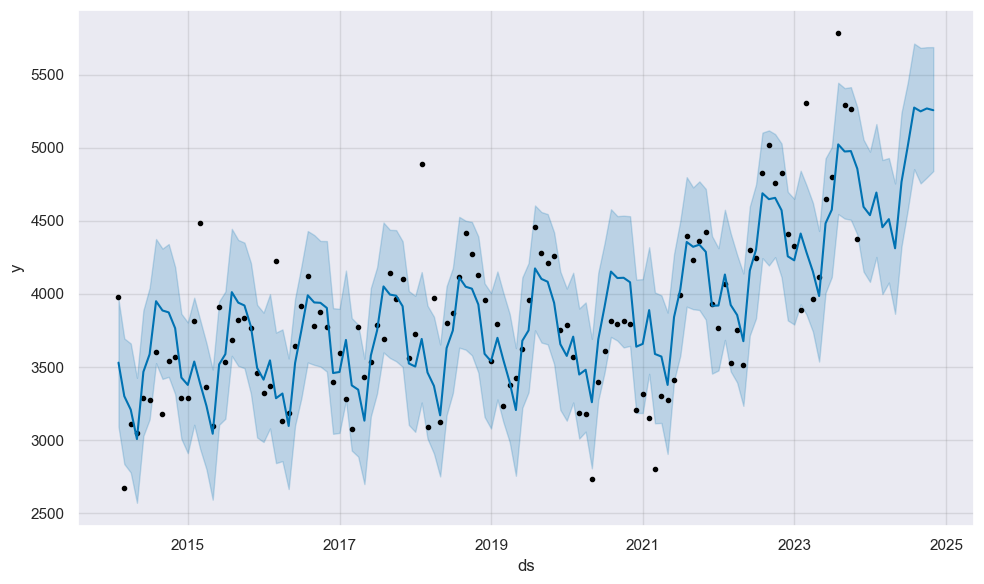

In [258]:

#predict incident data for the year 2024 - 2025

#Aggregate data to the desired frequency, e.g., monthly
monthly_data = data.resample('M', on='alarm_date').size().reset_index(name='incident_count')

# Rename columns for compatibility with Prophet
monthly_data.rename(columns={'alarm_date': 'ds', 'incident_count': 'y'}, inplace=True)

# Initialize the Prophet model
model = Prophet()

# Fit the model with all data up to the end of 2023
model.fit(monthly_data[monthly_data['ds'].dt.year <= 2023])

# Create a future DataFrame that includes 2024
future = model.make_future_dataframe(periods=12, freq='M')  # Adjust the periods if you need more than 12 months

# Predict the future incidents
forecast = model.predict(future)

# Plot the forecast
fig = model.plot(forecast)

# Filter the forecast for 2024 predictions
forecast_2024 = forecast[forecast['ds'].dt.year == 2024]
print(forecast_2024[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])

In [260]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Assuming 'data' is your DataFrame

# Convert 'alarm_time' to seconds from midnight
data['alarm_time'] = pd.to_timedelta(data['alarm_time']).dt.total_seconds()

# Selecting the numerical features for the regression model
features = ['alarm_time', 'incident_type']  # Add other numeric feature names here
target = 'estimated_property_loss'

# Split the data into features and target
X = data[features]
y = data[target]

# Handle missing values for features and target
X = X.fillna(X.mean())  # or X.dropna() if you want to remove rows with missing values
y = y.fillna(y.mean())  # or y.dropna()

X.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the linear regression model
lm = LinearRegression()

# Fit the model
lm.fit(X_train, y_train)

# Make predictions
y_pred = lm.predict(X_test)

# Print out the coefficients
print(f'Coefficients: {lm.coef_}')

# The mean squared error
print(f'Mean squared error (MSE): {mean_squared_error(y_test, y_pred)}')

# The coefficient of determination: 1 is perfect prediction
print(f'Coefficient of determination (R^2): {r2_score(y_test, y_pred)}')


Coefficients: [ -0.01600161 -10.21059733]
Mean squared error (MSE): 27275773517.30607
Coefficient of determination (R^2): 0.00032935686060697744


In [307]:
lm

LinearRegression()